In [1]:
# Import necessary packages
import matplotlib.pylab as plt

import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import torch
import numpy as np
import xarray

In [2]:
# Read in the dataset
data = pd.read_csv("../datasets/dag_data.csv")

# Construct a DAG model in Pyro to experiment with interventions and conditional modeling

### 1. Construct a DAG using the pgmpy Python package, fit the DAG on the dataset, then   extract conditional probability tables for each variable.

#### Construct a DAG using the pgmpy package.
We will model interventions and inferences on the DAG using the Pyro data science package for Python, but loading the data into a pygmy Bayesian network will allow us to easily transfer large conditional probability tables to Pyro. 

In [3]:
# Create a Bayesian model using pgmpy to represent the DAG.
bayes_model = BayesianModel([('CPL', 'CDC'), ('HS', 'CDC'), ('MI', 'CDC'), ('CDC', 'CC'), 
                          ('UI', 'ICU'),('ICU', 'CC'), ('SPL', 'BLG'), ('BLG', 'CC')])

#### Fit the model on the cleaned dataset.

In [4]:
# Fit the Bayesian model on the dataset.
bayes_model.fit(data)

#### Extract conditional probability tables for every variable in the DAG.

In [17]:
# Extract labels, probability tables, and a list of incoming variables for each variable in the DAG.
# CPL labels and probabilities
cpl_cpd = bayes_model.get_cpds(node="CPL")
cpl_labels, cpl_proba = cpl_cpd.state_names["CPL"], torch.tensor(cpl_cpd.values.T)

#ICU labels, probabilities, and input variables
icu_cpd = bayes_model.get_cpds(node="ICU")
icu_labels, icu_proba = icu_cpd.state_names["ICU"], torch.tensor(icu_cpd.values.T)
icu_input_vars = icu_cpd.variables

# CDC labels, probabilities, and input variables
cdc_cpd = bayes_model.get_cpds(node="CDC")
cdc_labels, cdc_proba = cdc_cpd.state_names["CDC"], torch.tensor(cdc_cpd.values.T)
cdc_input_vars = cdc_cpd.variables

# HS labels and probabilities
hs_cpd = bayes_model.get_cpds(node="HS")
hs_labels, hs_proba = hs_cpd.state_names["HS"], torch.tensor(hs_cpd.values.T)

# MI labels and probabilities
mi_cpd = bayes_model.get_cpds(node="MI")
mi_labels, mi_proba = mi_cpd.state_names["MI"], torch.tensor(mi_cpd.values.T)

# UI labels and probabilities
ui_cpd = bayes_model.get_cpds(node="UI")
ui_labels, ui_proba = ui_cpd.state_names["UI"], torch.tensor(ui_cpd.values.T)

# SPL labels and probabilities
spl_cpd = bayes_model.get_cpds(node="SPL")
spl_labels, spl_proba = spl_cpd.state_names["SPL"], torch.tensor(spl_cpd.values.T)

# BLG labels, probabilities, and input variables
blg_cpd = bayes_model.get_cpds(node="BLG")
blg_labels, blg_proba = blg_cpd.state_names["BLG"], torch.tensor(blg_cpd.values.T)
blg_input_vars = blg_cpd.variables

# CC labels, probabilities, and input variables
cc_cpd = bayes_model.get_cpds(node="CC")
cc_labels, cc_proba = cc_cpd.state_names["CC"], torch.tensor(cc_cpd.values.T)
cc_input_vars = cc_cpd.variables

cpl_proba

tensor([0.0266, 0.0522, 0.0565, 0.6575, 0.0431, 0.0673, 0.0969],
       dtype=torch.float64)

### 2. Construct a DAG in Pyro, built upon the conditional probability tables extracted from the pgmpy Bayesian network.

In [18]:
def cc_pyro_model():
    CPL = pyro.sample("CPL", dist.Categorical(probs=cpl_proba)) 
    HS = pyro.sample("HS", dist.Categorical(probs=hs_proba)) 
    MI = pyro.sample("MI", dist.Categorical(probs=mi_proba)) 
    UI = pyro.sample("UI", dist.Categorical(probs=ui_proba))
    SPL = pyro.sample("SPL", dist.Categorical(probs=spl_proba))
    CDC = pyro.sample("CDC", dist.Categorical(probs=cdc_proba[MI][HS][CPL]))
    ICU = pyro.sample("ICU", dist.Categorical(probs=icu_proba[UI]))
    BLG = pyro.sample("BLG", dist.Categorical(probs=blg_proba[SPL]))
    CC = pyro.sample("CC", dist.Categorical(probs=cc_proba[ICU][CDC][BLG]))
    return{"CPL": CPL, "CDC": CDC, "HS" : HS, "MI": MI, "UI": UI,
           "ICU": ICU, "SPL" : SPL, "BLG" : BLG, "CC" : CC} 

print(cc_pyro_model())

{'CPL': tensor(3), 'CDC': tensor(0), 'HS': tensor(0), 'MI': tensor(1), 'UI': tensor(2), 'ICU': tensor(1), 'SPL': tensor(1), 'BLG': tensor(5), 'CC': tensor(2)}


# Test Hypotheses about the Data

In [19]:
def test_var_effect(model, j):
    A_posterior = pyro.infer.Importance(model, num_samples=50).run() 
    A_marginal = EmpiricalMarginal(A_posterior,"CC")
    A_samples = [A_marginal().item() for _ in range(50)]
    A_unique, A_counts = np.unique(A_samples, return_counts=True)
    samples = [s for s in A_samples if s == j]
    return len(samples)/len(A_samples)

### Hypothesis 1. Counties in which there are fewer ICU beds report fewer COVID-19 confirmed cases per 100,000 people. 

In [23]:
# Evaluate and plot conditioned probabilities of county covid cases for each category of ICU bed availability
icu_hypothesis_dict = {}

for i in range(len(icu_labels)):
    icu_conditioned_model = pyro.condition(cc_pyro_model, data={'ICU':torch.tensor(i)})
    probability_dict = {}
    for j in range(len(cc_labels)):
        probability_dict[cc_labels[j]]= test_var_effect(icu_conditioned_model, j)
    reordered_cc = ["Very Low", "Low", "Medium", "High", "Very High"]
    reordered_dict = {i: probability_dict[i] for i in reordered_cc}
    icu_hypothesis_dict[icu_labels[i]] = reordered_dict
    print(icu_labels[i], icu_hypothesis_dict[icu_labels[i]])


High {'Very Low': 0.1, 'Low': 0.32, 'Medium': 0.24, 'High': 0.32, 'Very High': 0.34}
Low {'Very Low': 0.2, 'Low': 0.2, 'Medium': 0.22, 'High': 0.38, 'Very High': 0.42}
Medium {'Very Low': 0.3, 'Low': 0.26, 'Medium': 0.16, 'High': 0.4, 'Very High': 0.3}
Very High {'Very Low': 0.28, 'Low': 0.18, 'Medium': 0.16, 'High': 0.2, 'Very High': 0.1}


No handles with labels found to put in legend.


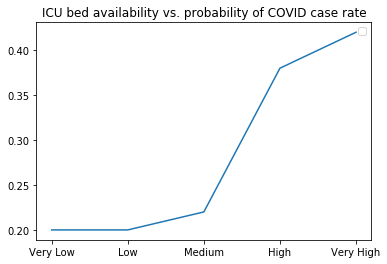

In [26]:
icu_order = ["Low", "Medium", "High", "Very High"]

reordered_dict = {i: icu_hypothesis_dict[i] for i in icu_order}

data = icu_hypothesis_dict["Low"]
names = list(data.keys())
values = list(data.values())
plt.plot(names, values)
plt.legend() 
plt.title("ICU bed availability vs. probability of COVID case rate")
plt.show()

###  Hypothesis 2. Counties that ban large gatherings report more COVID-19 confirmed cases per 100,000 people.